In [1]:
import os
import fiona
import pandas as pd
import json
import geopandas as gpd
from shapely.geometry import Polygon

# BRO Soil map dataset

--> This dataset is a multi-layered soil database that includes pedological properties and land characteristics.

## Load data

In [9]:
type_of_data = "soil_composition"

current_dir = os.getcwd()
datasetdir = os.path.join(current_dir, '../../data/raw', type_of_data)
path = os.path.join(datasetdir, "BRO-SGM-DownloadBodemkaart-V2024-01_1.gpkg")

In [10]:
layers = fiona.listlayers(path)
layers

['areaofpedologicalinterest',
 'soilarea',
 'nga_properties',
 'soilmap',
 'normalsoilprofiles',
 'normalsoilprofiles_landuse',
 'soilhorizon',
 'soilhorizon_fractionparticlesize',
 'soillayer',
 'soil_units',
 'soilcharacteristics_bottomlayer',
 'soilcharacteristics_toplayer',
 'soilarea_normalsoilprofile',
 'soilarea_soilunit',
 'soilarea_soilunit_soilcharacteristicstoplayer',
 'soilarea_soilunit_soilcharacteristicsbottomlayer']

## Load needed layers

In [4]:
# NOTE: "normalsoilprofile" cannot be joined to any table as it does not have id number. Lower and Upper values are constant (0, 1.2) so we dont need this table at all. Work only with "soilhorizon"!

In [11]:
soilarea = gpd.read_file(path, layer="soilarea")  # table with geo
soilarea_normalsoilprofile = gpd.read_file(path, layer="soilarea_normalsoilprofile") # relationship between soilarea and horizon
horizon = gpd.read_file(path, layer="soilhorizon")   # table with soil characteristics
soilarea_soilunit  = gpd.read_file(path, layer="soilarea_soilunit")
soil_units = gpd.read_file(path, layer="soil_units")

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: Unexpected data type for record 1 in column validfrom
  return ogr_read(


In [12]:
soil_units.iloc[77]['url']

'https://legenda-bodemkaart.bodemdata.nl/bodemklasse/Rn95A'

In [15]:
soil_units[soil_units['code'] == 'zWp']

,code,soilclassification,mainsoilclassification,url
121,zWp,Moerige podzolgronden met een humushoudend zan...,Moerige gronden,https://legenda-bodemkaart.bodemdata.nl/bodemk...


In [14]:
soil_units['url'][0]

'https://legenda-bodemkaart.bodemdata.nl/bodemklasse/BKh26'

## Adjustments in layer selection

In [6]:
# choose soil layer
layernumber = 1

soilarea_soilunit = soilarea_soilunit[soilarea_soilunit["soilunit_sequencenumber"]==0].copy()
horizon = horizon[horizon["layernumber"]==layernumber]

In [7]:
len(soilarea)

47716

In [8]:
len(soilarea_soilunit)

47716

In [9]:
len(horizon)

368

## Merge data

In [10]:
soilarea = soilarea[["maparea_id", "geometry"]]    # here we keep only necessary columns

merged = soilarea.merge(soilarea_soilunit, on="maparea_id")
merged = merged.merge(soilarea_normalsoilprofile, on="maparea_id")
merged = merged.merge(horizon, on="normalsoilprofile_id")

len(merged)

47716

In [11]:
merged.isna().sum()

maparea_id                         0
geometry                           0
soilunit_code                      0
soilunit_sequencenumber            0
normalsoilprofile_id               0
layernumber                        0
faohorizonnotation                 0
lowervalue                         0
uppervalue                         0
staringseriesblock                 0
organicmattercontent               0
minimumorganicmattercontent        0
maximumorganicmattercontent        0
acidity                            0
minimumacidity                     0
maximumacidity                     0
cnratio                            0
peattype                       41953
calciccontent                      0
fedith                             0
loamcontent                        0
minimumloamcontent                 0
maximumloamcontent                 0
lutitecontent                      0
minimumlutitecontent               0
maximumlutitecontent               0
sandmedian                         0
m

--> In one polygon we have values for five levels of soil

In [12]:
horizon_code_with_geom = merged[["layernumber", "organicmattercontent", "lutitecontent", "soilunit_code", "geometry"]].copy()
horizon_code_with_geom

,layernumber,organicmattercontent,lutitecontent,soilunit_code,geometry
0,1,3.4,7,bEZ23,"POLYGON ((264443.688 490779.125, 264438.719 49..."
1,1,3.4,7,bEZ23,"POLYGON ((262959.156 490607.469, 262969.75 490..."
2,1,3.4,7,bEZ23,"POLYGON ((265353.153 490906.673, 265298.719 49..."
3,1,3.4,7,bEZ23,"POLYGON ((261023.828 491051.844, 261036.469 49..."
4,1,1.7,14,BLb6,"POLYGON ((179409.984 311098.313, 179374.984 31..."
...,...,...,...,...,...
47711,1,3.5,2,Zn21,"POLYGON ((146300 600878, 146177.984 600885, 14..."
47712,1,3.5,2,Zn21,"POLYGON ((148354.984 601047.938, 148414 601084..."
47713,1,3.5,2,Zn21,"POLYGON ((148256 601312, 148233 601317, 148214..."
47714,1,3.5,2,Zn21,"POLYGON ((147748 601254, 147798.984 601266, 14..."


In [13]:
# NOTE: select 1st, 4th, 5th layer numbers! (most important in the key research paper)

## Crop the map

In [14]:
soil_geo = gpd.GeoDataFrame(horizon_code_with_geom, geometry="geometry")

In [15]:
def aoi_finder():
    # load Utrecht polygon coordinates
    utrecht_polygon_path = os.path.join(datasetdir, "..", "utrecht polygon.csv")
    df = pd.read_csv(utrecht_polygon_path, sep=';')

    geo_shape_str = df.loc[0, "Geo Shape"] #coordinates of the polygon
    geo_shape = json.loads(geo_shape_str)
    coords = geo_shape["coordinates"][0]  # outer ring of the polygon

    utrecht_polygon = Polygon(coords)

    # define boundary line
    x1, y1 = 5.066884, 52.170366  # upper-left
    x2, y2 = 5.237030, 51.978896  # lower-right

    def is_above_line(x, y):
        """Returns True if point (x, y) is above the diagonal line"""
        if x1 == x2:
            return y > y1  # vertical line
        slope = (y2 - y1) / (x2 - x1)
        y_on_line = slope * (x - x1) + y1
        return (y > y_on_line) and (x > x1)

    # Filter polygon coordinates
    filtered_coords = [
        (x, y) for x, y in utrecht_polygon.exterior.coords
        if is_above_line(x, y)]

    # Make sure polygon closes properly
    if filtered_coords[0] != filtered_coords[-1]:
        filtered_coords.append(filtered_coords[0])

    #new precise polygon
    aoi = Polygon(filtered_coords)

    utrecht_mask = gpd.GeoDataFrame(geometry=[aoi], crs="EPSG:4326")
    return utrecht_mask

In [16]:
utrecht_mask = aoi_finder()
utrecht_mask_rd = utrecht_mask.to_crs(soil_geo.crs)
cropped_gdf = gpd.overlay(soil_geo, utrecht_mask_rd, how='intersection')

In [17]:
cropped_gdf

,layernumber,organicmattercontent,lutitecontent,soilunit_code,geometry
0,1,3.4,7,bEZ23,"POLYGON ((164717.594 454012.75, 164756.969 454..."
1,1,3.1,7,bEZ23,"POLYGON ((160216.327 456809.549, 160205.744 45..."
2,1,3.4,7,bEZ23,"POLYGON ((161520.938 457135.313, 161480.375 45..."
3,1,3.4,7,bEZ23,"POLYGON ((161584.516 460209.687, 161567.031 46..."
4,1,3.4,7,bEZ23,"POLYGON ((161526.375 462600.313, 161516.016 46..."
...,...,...,...,...,...
1316,1,5.5,4,pZn21,"POLYGON ((160314.885 456824.101, 160330.098 45..."
1317,1,5.0,4,zWz,"POLYGON ((168822.397 446897.569, 168815.106 44..."
1318,1,9.0,4,zWp,"POLYGON ((138215 464499, 138212 464382, 138216..."
1319,1,9.0,4,zWp,"POLYGON ((139543 461581, 139519.405 461552.257..."


## Organic matter content

--> Might seem that almost all Polygons have the same value but thats because many polygons have very low vaues (but they are different!). Try changing the threshold of values included in cropped_gdf["organicmattercontent"] <= 5

<Axes: >

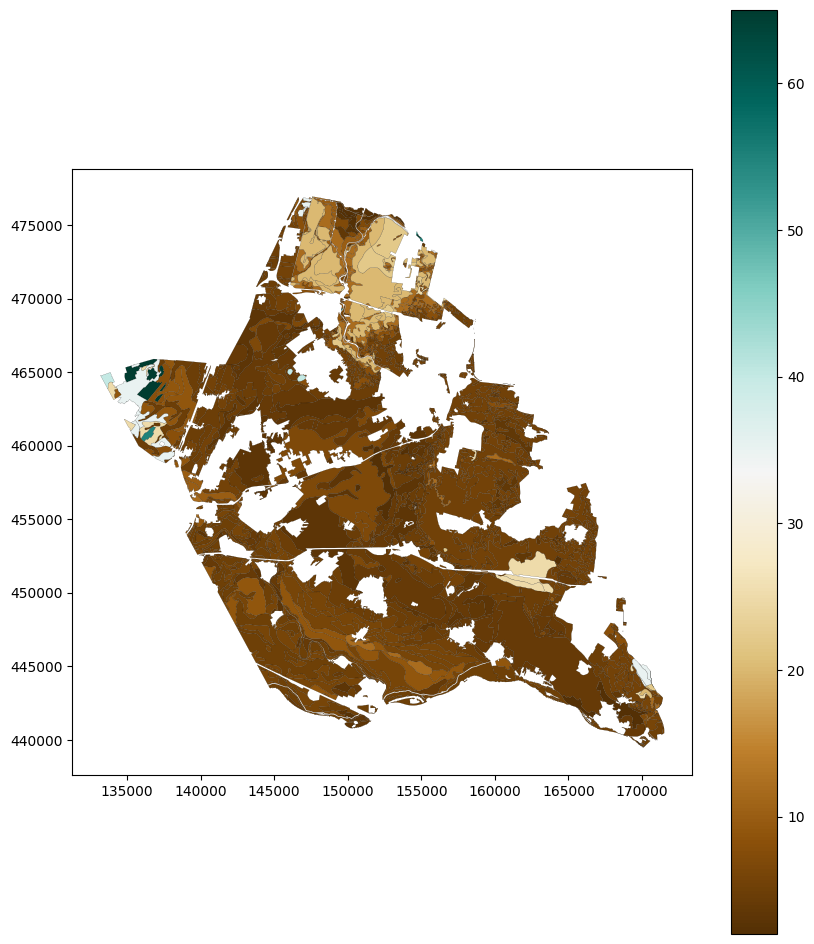

In [18]:
soil_geo_valid = cropped_gdf[cropped_gdf["organicmattercontent"].notna()]

soil_geo_valid.plot(
    column="organicmattercontent",
    cmap="BrBG",
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    figsize=(10, 12)
)

## Lutite content

<Axes: >

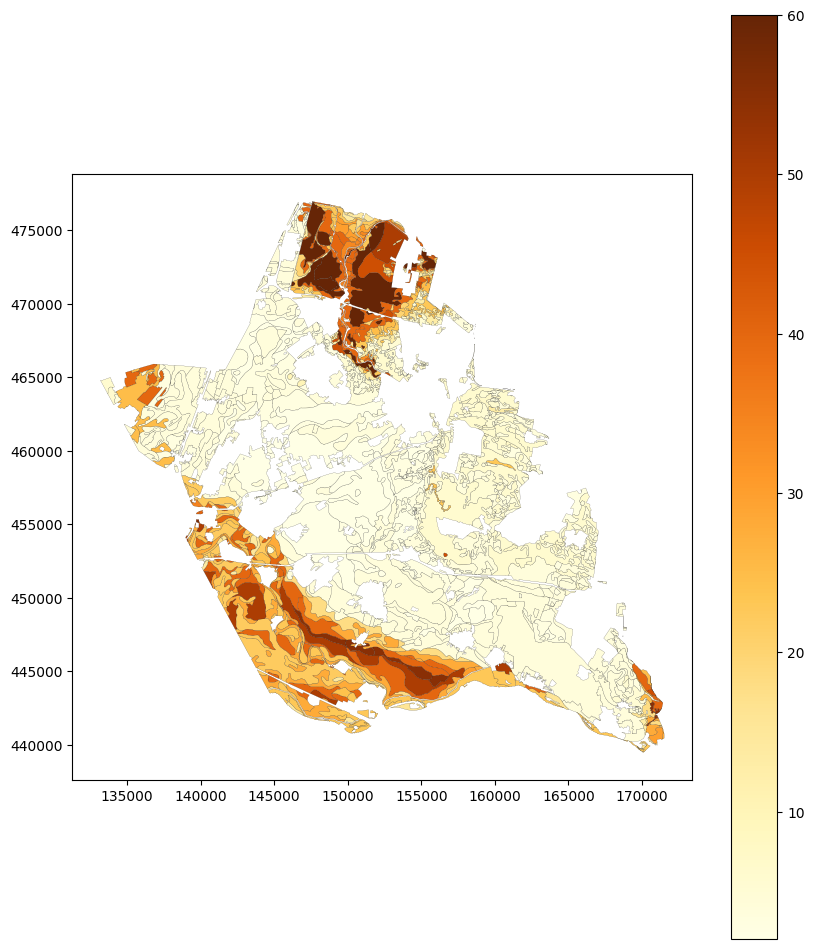

In [19]:
soil_geo_valid = cropped_gdf[cropped_gdf["lutitecontent"].notna()]

soil_geo_valid.plot(
    column="lutitecontent",
    cmap="YlOrBr",
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    figsize=(10, 12)
)

## Soil Code

<Axes: >

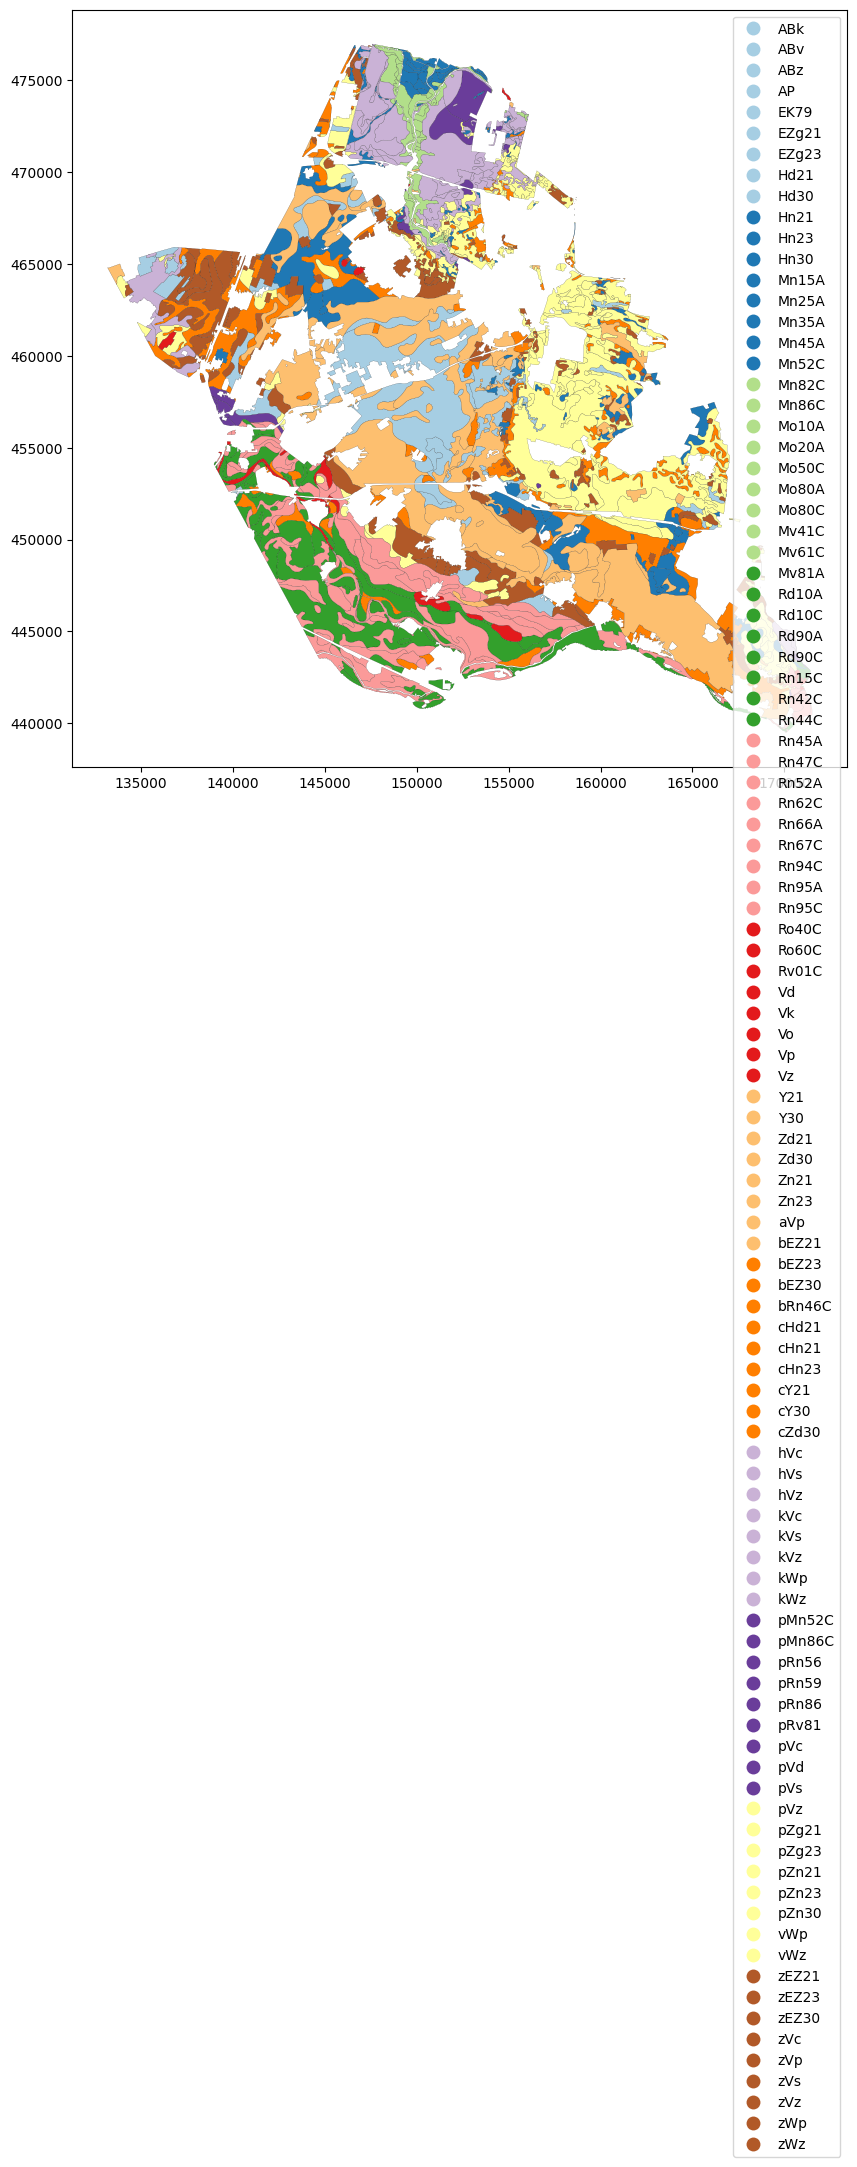

In [20]:
soil_geo_valid = cropped_gdf[cropped_gdf["soilunit_code"].notna()]

soil_geo_valid.plot(
    column="soilunit_code",
    cmap="Paired",
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    figsize=(10, 12)
)

In [7]:
path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/clean/soil_composition/layernumber_1_processed.gpkg"
gdf = gpd.read_file(path)

In [17]:
len(gdf.columns)

31